In [1]:
import cv2
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
from PIL import Image

import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F

from transformers import ViTFeatureExtractor, ViTModel
from sklearn.metrics.pairwise import cosine_distances

C:\Users\HONOR\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
#Для демонстрации результатов, мы загрузим несколько групп изображений.
#Сохраним их в массивы, в которых все элементы, кроме последнего принадлежат одной компании.
#Про последний элемент мы должны сказать, является ли он элементом этой компании

In [3]:
#загрузка некоторых изображений, взятых из датасетов.
#Для некоторых изображений, я обработал изображения заранее в фотошопе, и масштабировал их до 224 на 224, масштабировав именно размер логотипа
#с изображения. Можно сказать выделил кроп логотипа, о котором писалось в задании. Конкретно, это проделал со всеми изображения кроме
#логотипов компании ansco.
#В тестах с первого по шестой используются эти предобработанные мной изображения, в которых обрезан только фрагмент логотипа.
#Для тестов 7, 8, 9 я загрузил непредобработанные изображения, у которых я не обрезал кроп области с логотипом, для проверки, будут ли результаты
#отличаться.
apple1 = cv2.imread('image/apple1.png')
apple2 = cv2.imread('image/apple2.png')
apple3 = cv2.imread('image/apple3.png')
apple4 = cv2.imread('image/apple4.png')
apple5 = cv2.imread('image/apple5.png')
apple6 = cv2.imread('image/apple6.png')
apple7 = cv2.imread('image/apple7.png')
kava = cv2.imread('image/kava.jpg')
bridgeport = cv2.imread('image/bridgeport.jpg')
ansco1 = cv2.imread('image/ansco1.jpg')
ansco2 = cv2.imread('image/ansco2.jpg')
ansco3 = cv2.imread('image/ansco3.jpg')
ansco4 = cv2.imread('image/ansco4.jpg')
#Формирование массивов для тестов.
test_arr1 = [apple1, apple2, apple3, apple4, apple5, apple6, apple7]
test_arr2 = [apple1, apple2, apple3, apple4, apple5, apple6, apple7, kava]
test_arr3 = [apple1, apple2, apple3, apple4, apple5, apple6, apple7, bridgeport]
test_arr4 = [ansco1, ansco2, ansco3, ansco4]
test_arr5 = [ansco1, ansco2, ansco3, ansco4, kava]
test_arr6 = [ansco1, ansco2, ansco3, ansco4, bridgeport]
#Загрузка необработанных изображений
apple1no = cv2.imread('image/appleno1.jpg')
apple2no = cv2.imread('image/appleno2.jpg')
apple3no = cv2.imread('image/appleno3.jpg')
apple4no = cv2.imread('image/appleno4.jpg')
apple5no = cv2.imread('image/appleno5.jpg')
apple6no = cv2.imread('image/appleno6.jpg')
apple7no = cv2.imread('image/appleno7.jpg')
kavano = cv2.imread('image/kavano.jpg')
bridgeportno = cv2.imread('image/bridgeportno.jpg')
#Формирование тестов с непредобработанными изображениями
test_arr7 = [apple1no, apple2no, apple3no, apple4no, apple5no, apple6no, apple7no]
test_arr8 = [apple1no, apple2no, apple3no, apple4no, apple5no, apple6no, apple7no, kavano]
test_arr9 = [apple1no, apple2no, apple3no, apple4no, apple5no, apple6no, apple7no, bridgeportno]

In [4]:
#Функция для отображения массива изображений, необходим для наглядности демонстрации, что и с чем наша система сравнивает.
def show_images(image_list):
    rows = 1
    cols = len(image_list)

    fig, axes = plt.subplots(rows, cols, figsize=(8, 2))
    axes = axes.flatten()
    
    for i in range(len(image_list)):
        image_rgb = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB)  
        axes[i].imshow(image_rgb)
        axes[i].axis('off')
    plt.show()

In [5]:
#Функция, которая стандартизует размер изображений, делая их 224 на 224.
#Если изображение не квадратных пропорций, то оно изменит его размер, чтобы оно вписывалось в 224 на 224.
#И дорисует по бокам пиксели черного цвета, чтобы дать модели на вход именно квадраь 224 на 224
def resize_with_padding(image, target_size):
    h, w, _ = image.shape
    target_h, target_w = target_size
    scale_h = target_h / h
    scale_w = target_w / w
    scale = min(scale_h, scale_w)

    resized_h = int(h * scale)
    resized_w = int(w * scale)
    resized_image = cv2.resize(image, (resized_w, resized_h))

    pad_top = (target_h - resized_h) // 2
    pad_bottom = target_h - resized_h - pad_top
    pad_left = (target_w - resized_w) // 2
    pad_right = target_w - resized_w - pad_left
    
    padded_image = cv2.copyMakeBorder(resized_image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [6]:
#Обработка изображений. Перевод в RGB и в тензор, нормализация.
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [7]:
#Функция получения эмбендингов изображения используя для этого предобуенный resNet без последнего слоя 
#(последний слой отвечает за классификацию изображений, поэтому его можно удалить)

def get_embeddings(image_tensors):
    embedding_model = models.resnet50(pretrained=True)
    embedding_model = nn.Sequential(*list(embedding_model.children())[:-1])
    
    embedding_model.eval()
    embeddings = []
    with torch.no_grad():
        for tensor in image_tensors:
            tensor = tensor.unsqueeze(0)
            embedding = embedding_model(tensor)
            embeddings.append(embedding)

    return embeddings

In [8]:
#Функция для подсета косинусных расстояний между эмбендингами
from numpy.linalg import norm
def cosine_distance(embedding1, embedding2):
    embedding1 = embedding1.detach().cpu().numpy().astype(float)
    embedding2 = embedding2.detach().cpu().numpy().astype(float)
    embedding1 = embedding1.flatten()
    embedding2 = embedding2.flatten()

    cosine_similarity = np.dot(embedding1, embedding2) / (norm(embedding1) * norm(embedding2))
    cosine_distance = 1 - cosine_similarity

    return cosine_distance

In [9]:
#Функция для проверки, относится ли последний логотип из массива к логотипам компании.
def decide(arr):
    summ = 0
    maxx = 0
    for i in range(len(arr)-1):
        for j in range(i, len(arr) - 1):
            length = cosine_distance(embeddings[i], embeddings[j])
            summ += length
            if length > maxx:
                maxx = length
    count = ((len(arr) - 1) * (len(arr) - 2)) // 2
    average = summ / count
    
    summ2 = 0
    for i in range(len(arr) - 1):
        summ2 += cosine_distance(embeddings[i], embeddings[len(arr) - 1])
    average2 = summ2 / (len(arr) - 1)
    
    if average2 < average + 0.7 * (maxx - average):
        print("Это логотип нашей компании")
    else:
        print("Это другая компания")

In [10]:
#Первый тест

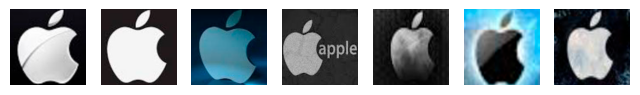

In [11]:
for i in range(len(test_arr1)):
    test_arr1[i] = resize_with_padding(test_arr1[i], (224, 224))
show_images(test_arr1)

In [12]:
for i in range(len(test_arr1)):
    test_arr1[i] = transform(test_arr1[i])

In [13]:
embeddings = get_embeddings(test_arr1)

C:\Users\HONOR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HONOR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
import itertools
for i, j in itertools.combinations(range(len(embeddings)), 2):
    distance = cosine_distance(embeddings[i], embeddings[j])
    print(f"Cosine distance between embedding {i+1} and embedding {j+1}: {distance}")

Cosine distance between embedding 1 and embedding 2: 0.11655621807134642
Cosine distance between embedding 1 and embedding 3: 0.16940668699723382
Cosine distance between embedding 1 and embedding 4: 0.26988377158583454
Cosine distance between embedding 1 and embedding 5: 0.21605743362471708
Cosine distance between embedding 1 and embedding 6: 0.3950907032666465
Cosine distance between embedding 1 and embedding 7: 0.28028087423921855
Cosine distance between embedding 2 and embedding 3: 0.2511503246351545
Cosine distance between embedding 2 and embedding 4: 0.241487387476785
Cosine distance between embedding 2 and embedding 5: 0.21208436228987948
Cosine distance between embedding 2 and embedding 6: 0.42012741798292497
Cosine distance between embedding 2 and embedding 7: 0.27723865302373996
Cosine distance between embedding 3 and embedding 4: 0.35536816191611365
Cosine distance between embedding 3 and embedding 5: 0.2893325765045025
Cosine distance between embedding 3 and embedding 6: 0.4

In [15]:
decide(test_arr1)

Это логотип нашей компании


In [16]:
#тест 2

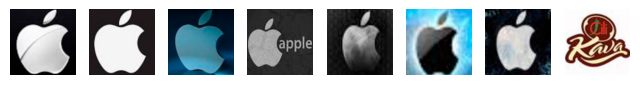

In [17]:
for i in range(len(test_arr2)):
    test_arr2[i] = resize_with_padding(test_arr2[i], (224, 224))
show_images(test_arr2)

In [18]:
for i in range(len(test_arr2)):
    test_arr2[i] = transform(test_arr2[i])
embeddings = get_embeddings(test_arr2)

In [19]:
decide(test_arr2)

Это другая компания


In [20]:
#тест 3

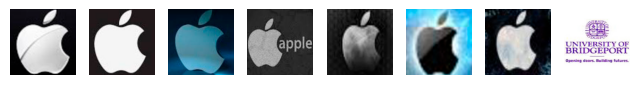

In [21]:
for i in range(len(test_arr3)):
    test_arr3[i] = resize_with_padding(test_arr3[i], (224, 224))
show_images(test_arr3)

In [22]:
for i in range(len(test_arr3)):
    test_arr3[i] = transform(test_arr3[i])
embeddings = get_embeddings(test_arr3)
decide(test_arr3)

Это другая компания


In [23]:
# тест 4

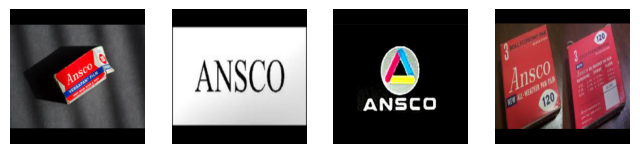

In [24]:
for i in range(len(test_arr4)):
    test_arr4[i] = resize_with_padding(test_arr4[i], (224, 224))
show_images(test_arr4)

In [25]:
for i in range(len(test_arr4)):
    test_arr4[i] = transform(test_arr4[i])
embeddings = get_embeddings(test_arr4)
decide(test_arr4)

Это логотип нашей компании


In [26]:
# тест 5

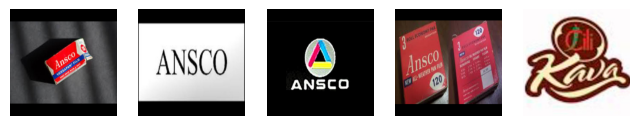

In [27]:
for i in range(len(test_arr5)):
    test_arr5[i] = resize_with_padding(test_arr5[i], (224, 224))
show_images(test_arr5)

In [28]:
for i in range(len(test_arr5)):
    test_arr5[i] = transform(test_arr5[i])
embeddings = get_embeddings(test_arr5)
decide(test_arr5)

Это другая компания


In [29]:
# тест 6

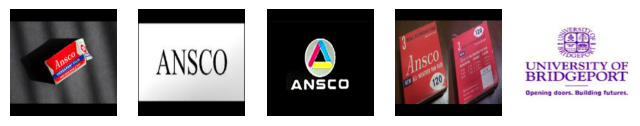

In [30]:
for i in range(len(test_arr6)):
    test_arr6[i] = resize_with_padding(test_arr6[i], (224, 224))
show_images(test_arr6)

In [31]:
for i in range(len(test_arr6)):
    test_arr6[i] = transform(test_arr6[i])
embeddings = get_embeddings(test_arr6)
decide(test_arr6)

Это другая компания


In [32]:
#тест 7

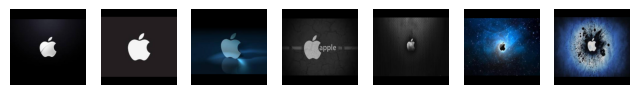

In [33]:
for i in range(len(test_arr7)):
    test_arr7[i] = resize_with_padding(test_arr7[i], (224, 224))
show_images(test_arr7)

In [34]:
for i in range(len(test_arr7)):
    test_arr7[i] = transform(test_arr7[i])
embeddings = get_embeddings(test_arr7)
decide(test_arr7)

Это логотип нашей компании


In [35]:
#тест 8

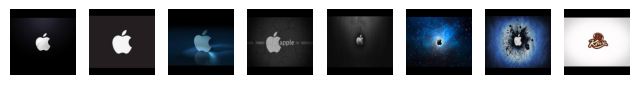

In [36]:
for i in range(len(test_arr8)):
    test_arr8[i] = resize_with_padding(test_arr8[i], (224, 224))
show_images(test_arr8)

In [37]:
for i in range(len(test_arr8)):
    test_arr8[i] = transform(test_arr8[i])
embeddings = get_embeddings(test_arr8)
decide(test_arr8)

Это другая компания


In [38]:
#тест 9

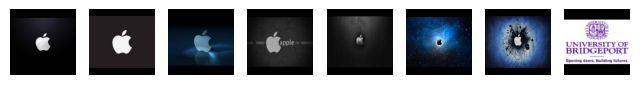

In [39]:
for i in range(len(test_arr9)):
    test_arr9[i] = resize_with_padding(test_arr9[i], (224, 224))
show_images(test_arr9)

In [40]:
for i in range(len(test_arr9)):
    test_arr9[i] = transform(test_arr9[i])
embeddings = get_embeddings(test_arr9)
decide(test_arr9)

Это другая компания


In [42]:
#Как итог все тесты прошли. Хотя конечно скорее всего можно найти много примеров, где тесты не пройдут. ResNet - вероятно может справляться с задачей
#Но требуется тест на большом колиестве данных и стоит до обучить модель для более высокого качетсва.

In [46]:
#Негативный пример! Когда метод не сработал.

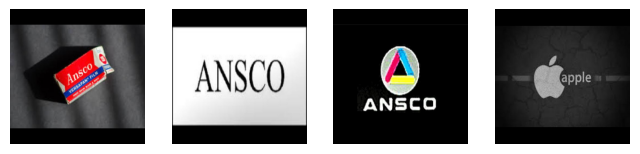

In [44]:
test_arr10 = [ansco1, ansco2, ansco3, apple4no]
for i in range(len(test_arr10)):
    test_arr10[i] = resize_with_padding(test_arr10[i], (224, 224))
show_images(test_arr10)

In [45]:
for i in range(len(test_arr10)):
    test_arr10[i] = transform(test_arr10[i])
embeddings = get_embeddings(test_arr10)
decide(test_arr10)

Это логотип нашей компании
